<a href="https://colab.research.google.com/github/NSR9/Extensive-Vision-AI/blob/main/Assignment_4/Model_training/Session_4_assignment_NB_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Write MNIST code such that:

* 99.4% validation accuracy 
* Less than 20k Parameters
* You can use anything from above you want.
* Less than 20 Epochs

###Things used: - 

* 
* Activation Function as **ReLU** is used after conv layers
* **MaxPool Layer of 2 x 2** is used twice in the network. 
* **Conv 1X1** is used in the transition layer for reducing the number of channels
* Added **batch normalization** after every conv layer
* Added **dropout of 0.1** after each conv layer
* Added **Global average pooling** to get output classes.
* Use learning rate of 0.01 and momentum 0.9

####Parameters count reduced to as low as **15,970**

#### Achieved an highest accuracy of **99.50%** at the **16th Epoch**. Getting an accuracy of greater than **99.40%** for the first time at **12th epoch** itself.

## Calling out to the GODS (Importing Libs):

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns

## Network Block :

#### Conv Block 1
* 2D Convolution number of kernels 8, followed with Batch Normalization and 2D Dropout of 0.1 
* 2D Convolution number of kernels 16, followed with Batch Normalization and 2D Dropout of 0.1
* 2D Convolution number of kernels 32, followed with Batch Normalization and 2D Dropout of 0.1

#### Transition Layer 1
* 2D Max Pooling to reduce the size of the channel to 14
* 2d Convolution with kernel size 1 reducing the number of channels to 8

#### Conv Block 2
* 2D Convolution number of kernels 16, followed with Batch Normalization and 2D Dropout of 0.1 
* 2D Convolution number of kernels 16, followed with Batch Normalization and 2D Dropout of 0.1
* 2D Convolution number of kernels 16, followed with Batch Normalization and 2D Dropout of 0.1

#### Transition Layer 2
* 2D Max Pooling to reduce the size of the channel to 7

#### Conv Block 3
* 2D Convolution number of kernels 16, followed with Batch Normalization and 2D Dropout of 0.1 
* 2D Convolution number of kernels 10 (Avoid Batch Normalization and Dropout in Last layer before GAP)

#### Global Average Pooling
* Global Average pooling with a size 3 and no Padding to return a 10 x 1 x 1 as the value to go to log_softmax 

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding = 1) #28, 28
        self.conv1_bn = nn.BatchNorm2d(8) 
        self.dropout1 = nn.Dropout2d(0.1)

        self.conv2 = nn.Conv2d(8, 16, 3, padding = 1) #28, 28
        self.conv2_bn = nn.BatchNorm2d(16)
        self.dropout2 = nn.Dropout2d(0.1)

        self.conv9 = nn.Conv2d(16, 32, 3, padding = 1) #28, 28
        self.conv9_bn = nn.BatchNorm2d(32)
        self.dropout9 = nn.Dropout2d(0.1)
        
        self.pool1 = nn.MaxPool2d(2, 2) #28, 14
        self.conv3 = nn.Conv2d(32, 8, 1) #14, 14

        self.conv4 = nn.Conv2d(8, 16, 3, padding = 1 ) #14, 14
        self.conv4_bn = nn.BatchNorm2d(16)
        self.dropout4 = nn.Dropout2d(0.1)

        self.conv5 = nn.Conv2d(16, 16, 3, padding = 1) #14, 14
        self.conv5_bn = nn.BatchNorm2d(16)
        self.dropout5 = nn.Dropout2d(0.1)
        
        self.conv10 = nn.Conv2d(16, 16, 3, padding = 1) #14, 14
        self.conv10_bn = nn.BatchNorm2d(16)
        self.dropout10 = nn.Dropout2d(0.1)

        self.pool2 = nn.MaxPool2d(2, 2) #14, 7

        self.conv7 = nn.Conv2d(16, 16, 3) #7, 5
        self.conv7_bn = nn.BatchNorm2d(16)
        self.dropout7 = nn.Dropout2d(0.1)

        self.conv8 = nn.Conv2d(16, 10, 3) #5, 3
        self.gap = nn.AvgPool2d(kernel_size=3, stride=1, padding = 0)

    def forward(self, x):
        #Conv Block 1
        x = self.dropout1(self.conv1_bn(F.relu(self.conv1(x))))
        x = self.dropout2(self.conv2_bn(F.relu(self.conv2(x))))
        x = self.dropout9(self.conv9_bn(F.relu(self.conv9(x))))

        #Transition Layer 1
        x = F.relu(self.conv3(self.pool1(x)))

        #Conv Block 2
        x = self.dropout4(self.conv4_bn(F.relu(self.conv4(x))))
        x = self.dropout5(self.conv5_bn(F.relu(self.conv5(x))))
        x = self.dropout10(self.conv10_bn(F.relu(self.conv10(x))))

        #Transition Layer 2
        x = self.pool2(x)

        #Conv Block 3
        x = self.dropout7(self.conv7_bn(F.relu(self.conv7(x))))
        x = self.conv8(x)

        # Global Average Pooling
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(x)

##Model Summary:

#### Params used 15,970

In [3]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
         Dropout2d-3            [-1, 8, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           1,168
       BatchNorm2d-5           [-1, 16, 28, 28]              32
         Dropout2d-6           [-1, 16, 28, 28]               0
            Conv2d-7           [-1, 32, 28, 28]           4,640
       BatchNorm2d-8           [-1, 32, 28, 28]              64
         Dropout2d-9           [-1, 32, 28, 28]               0
        MaxPool2d-10           [-1, 32, 14, 14]               0
           Conv2d-11            [-1, 8, 14, 14]             264
           Conv2d-12           [-1, 16, 14, 14]           1,168
      BatchNorm2d-13           [-1, 16, 14, 14]              32
        Dropout2d-14           [-1, 16,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [4]:
model.eval()

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.1, inplace=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout2d(p=0.1, inplace=False)
  (conv9): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout9): Dropout2d(p=0.1, inplace=False)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout2d(p=0.1, i

## Loading DataSet:


In [5]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation(5),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Train Test Functions:

In [6]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'epoch={epoch} loss={loss.item():.10f} batch_id={batch_idx:05d}')
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader)
    train_acc = 100.00*correct/len(train_loader.dataset)
    return train_acc, train_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc = 100.00 * correct / len(test_loader.dataset)
    return test_acc, test_loss


## Model Training:

In [9]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []

for epoch in range(1, 20):
    train_acc, train_loss = train(model, device, train_loader, optimizer, epoch)
    test_acc, test_loss = test(model, device, test_loader)

    train_accuracy_values.append(train_acc)
    train_loss_values.append(train_loss)

    test_accuracy_values.append(test_acc)
    test_loss_values.append(test_loss)

    


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0564, Accuracy: 9812/10000 (98.12%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9866/10000 (98.66%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9899/10000 (98.99%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9911/10000 (99.11%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9922/10000 (99.22%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9911/10000 (99.11%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9921/10000 (99.21%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9923/10000 (99.23%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.32%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9941/10000 (99.41%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9935/10000 (99.35%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9945/10000 (99.45%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9946/10000 (99.46%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9947/10000 (99.47%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9935/10000 (99.35%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9950/10000 (99.50%)



epoch=19 loss=0.0563756712 batch_id=00468: 100%|██████████| 469/469 [00:17<00:00, 26.35it/s]



Test set: Average loss: 0.0157, Accuracy: 9947/10000 (99.47%)



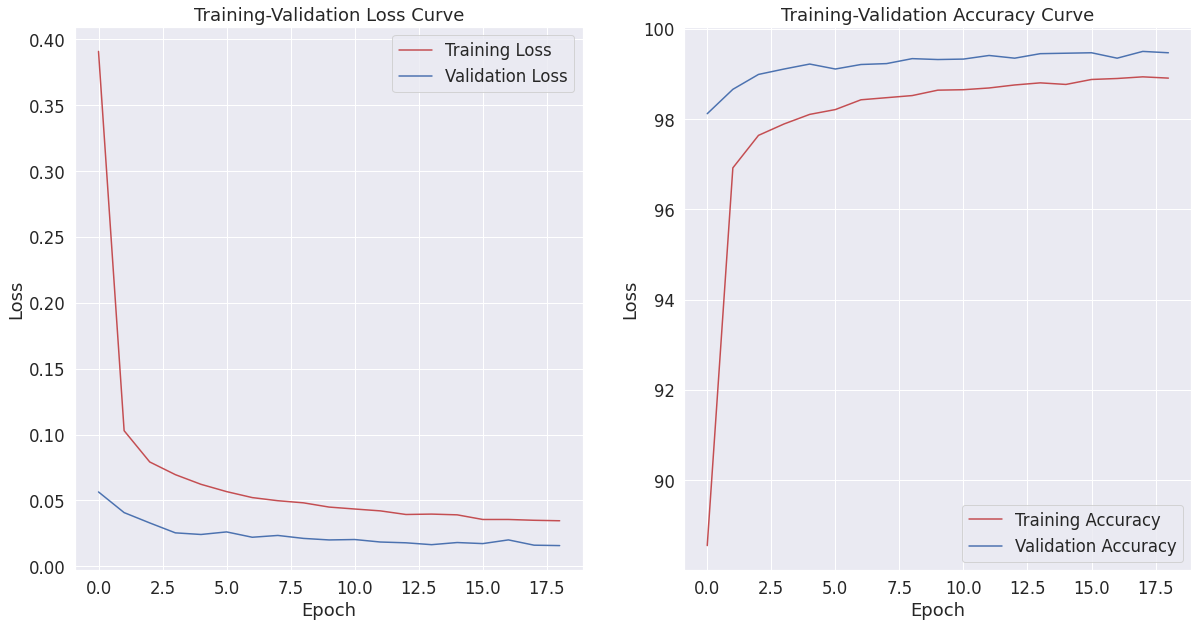

In [11]:
sns.set(style='whitegrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)

# Plot the learning curve.
fig, (plt1,plt2) = plt.subplots(1,2)
plt1.plot(np.array(train_loss_values), 'r', label="Training Loss")
plt1.plot(np.array(test_loss_values), 'b', label="Validation Loss")
plt2.plot(np.array(train_accuracy_values), 'r', label="Training Accuracy")
plt2.plot(np.array(test_accuracy_values), 'b', label="Validation Accuracy")

plt2.set_title("Training-Validation Accuracy Curve")
plt2.set_xlabel("Epoch")
plt2.set_ylabel("Loss")
plt2.legend()
plt1.set_title("Training-Validation Loss Curve")
plt1.set_xlabel("Epoch")
plt1.set_ylabel("Loss")
plt1.legend()

plt.show()